Essential libraries

In [9]:
import os
import sys
import numpy
import json
import subprocess
import isambard_dev
import operator
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')
%matplotlib notebook

In [2]:
mutant_names = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

In [3]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

modules_path = "/home/ba13026/mpmodeling/analysis/"
if modules_path not in sys.path:
    sys.path.append(modules_path)

import setup_geometry_interactions_db
import importlib
importlib.reload(setup_geometry_interactions_db)
from setup_geometry_interactions_db import \
    Json,Tags,RigidBody,RadialProfiles,Miscellaneous,Interhelix_Interactions, Base
from insert2db_geometry_interactions import interaction_direction

Essential files

In [4]:
wd = '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/md_relax/'
filename = wd+'filtered_ids_new.json'

with open(filename,'r') as fp:
    Filtered_IDs = json.load(fp)

In [5]:
wd = '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/md_relax/'
filename = wd+'filtered_ids_interaction_groups.json'

with open(filename,'r') as fp:
    Models_Out_IDs = json.load(fp)

Load DB stuff

In [6]:
# path0 = '/home/ba13026/dbs/'
path0 = '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/md_relax/'
dbfile = path0 + 'mutants_docked_geometry-interactions.db'
engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker()
DBSession.bind = engine
session = DBSession()

Filter out IDs according to interaction partition and extract PDB identity

In [8]:
MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation0'])
]

PARTITIONS = {}

for tags in MyTags:
    ##############################
    PARTITIONS[tags] = {}
    ##############################
    mutant, C_x = json.loads(tags)
    
    X_all = set(list(Filtered_IDs[mutant][C_x]))
    
    X_hbonds = set(Models_Out_IDs['hbonds'][tags])
    X_kihs = set(Models_Out_IDs['kihs'][tags])
    X_hbonds_NOT_kihs = set(X_hbonds - X_kihs)
    X_kihs_NOT_hbonds = set(X_kihs - X_hbonds)
    X_hbonds_AND_kihs = set(X_hbonds & X_kihs)
    X_hbonds_NOR_kihs = X_all - set(X_hbonds | X_kihs)
    
    Keys = ['hbonds_NOT_kihs', 'kihs_NOT_hbonds', 'hbonds_AND_kihs', 'hbonds_NOR_kihs']
    X_partitions = [X_hbonds_NOT_kihs, X_kihs_NOT_hbonds, X_hbonds_AND_kihs, X_hbonds_NOR_kihs]
    
    for key, S in list(zip(Keys, X_partitions)):
        PDBs = []
        for id in S:
            model_pdbs = session.query(Tags.pdb_name).filter_by(id = id).all()[0][0][:-4]
            PDBs.append(model_pdbs)
        PARTITIONS[tags][key] = PDBs

# Backbone - RMSD

## Random Sampling

**OPTION 1**
Original Sample 

In [9]:
name = 'md_100ns'
json_input = wd + 'EMMD_Sample.json'

with open(json_input,'r') as fp:
    param_list = json.load(fp)
    
refined_param_list = []
for model_dir in param_list:
    filename1 = name+".gro"
    filename2 = name+".xtc"
    file2check1 = wd+model_dir+'/complex/mdf/'+filename1
    file2check2 = wd+model_dir+'/complex/mdf/'+filename2
    if os.path.isfile(file2check1) and os.path.isfile(file2check2):
        refined_param_list.append(model_dir)

print(len(refined_param_list))

224


**OPTION 2** Modified sample with increased cWza-K373C models

In [13]:
mutant = 'cWza-K375C'
name = 'md_100ns'
filename = name+".xtc"

extra = []
for C in ['conformation0', 'conformation1']:
    mutant_dir = mutant+'/'+C 
    for model_dir in [mutant_dir+'/'+model for model in os.listdir(wd+mutant_dir)]:
        file2check = wd+model_dir+'/complex/mdf/'+filename
        if os.path.isfile(file2check):
            extra.append(model_dir)

In [14]:
refined_param_list = list(set(refined_param_list).union(set(extra)))
print(len(refined_param_list))

222


<IPython.core.display.Javascript object>


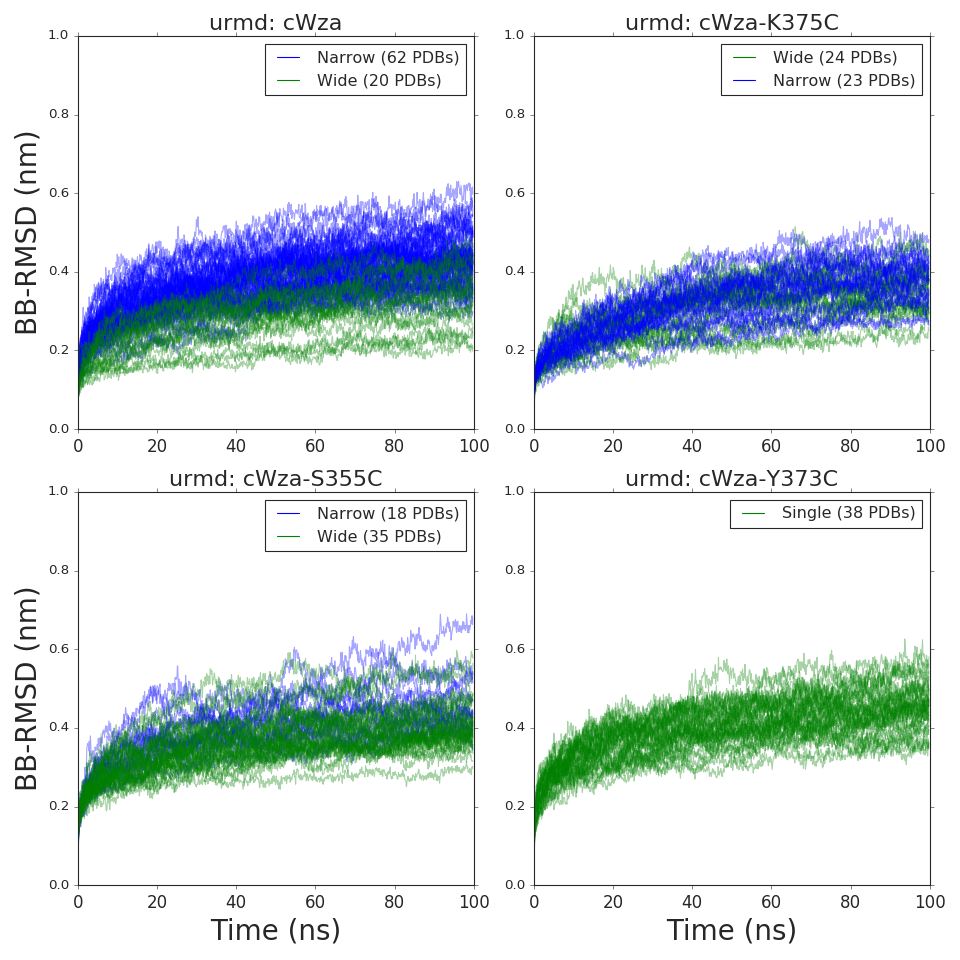

In [21]:
name = 'md_100ns'
atomic_group = 'Backbone'

fig, ax = plt.subplots(2,2,figsize=(12,12))

sns.set_style("white")

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

Colors = {
    'cWza':{'Narrow':'blue', 'Wide':'green'},
    'cWza-K375C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-S355C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-Y373C':{'Single':'green'}
}

Conformations = {
    'cWza':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-K375C':{'conformation1':'Narrow', 'conformation0':'Wide'},
    'cWza-S355C':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-Y373C':{'conformation1':'Single'}
}

def filter_XY(filename):
    lines = open(filename,'r').readlines()
    return [list(map(float,xy.split())) for xy in lines if (not "#" in xy) and (not "@" in xy)]

for tag in MyTags:
    mutant, group = json.loads(tag)
    ############################################
    COUNTER_model = 0
    for n in range(len(refined_param_list)):
        if refined_param_list[n].split('/')[0] == mutant and refined_param_list[n].split('/')[1] == group:
            try:
                filename = wd+refined_param_list[n]+'/complex/mdf/'+name+'_rmsd_'+atomic_group+'.xvg'
                data = filter_XY(filename)[:-2]
                if len(data)>10:
                    COUNTER_model += 1
                    X,Y = numpy.array(data).T
                    mycolor = Colors[mutant][Conformations[mutant][group]]
                    axes[mutant].plot(X,Y,color=mycolor,alpha=0.35)
            except:
                print("No RMSD data for this model: ", refined_param_list[n])
    ############################################
    # Add conformation labels
    mycolor = Colors[mutant][Conformations[mutant][group]]
    axes[mutant].plot([],[],label=Conformations[mutant][group]+" ("+str(COUNTER_model)+" PDBs)",color=mycolor)
    ############################################
    # Customise plot
    axes[mutant].set_xticklabels(range(0,110,20), fontsize=15)
#     axes[mutant].set_yticklabels(range(0,11,2), fontsize=15)
    axes[mutant].set_title("urmd: "+mutant, fontsize=20)
    axes[mutant].set_xlim(0,100000)
    axes[mutant].set_ylim(0,1)
    axes[mutant].legend(loc='best')

# More customisation
axes['cWza'].set_ylabel("BB-RMSD (nm)",fontsize=25)
axes['cWza-S355C'].set_ylabel("BB-RMSD (nm)",fontsize=25)
axes['cWza-S355C'].set_xlabel("Time (ns)",fontsize=25)
axes['cWza-Y373C'].set_xlabel("Time (ns)",fontsize=25)

fig.tight_layout()
plt.show()

Find those models for which md trajectories are available but RMSD hasn't been extracted

In [22]:
name = 'md_100ns'
atomic_group = 'Backbone'

remaining = []
for model_dir in refined_param_list:
    filename1 = name+".xtc"
    filename2 = name+'_rmsd_'+atomic_group+'.xvg'
    file2check1 = wd+model_dir+'/complex/mdf/'+filename1
    file2check2 = wd+model_dir+'/complex/mdf/'+filename2
    if os.path.isfile(file2check1) and not os.path.isfile(file2check2):
        remaining.append(model_dir)

In [23]:
remaining

[]

Save identity of models for RMSD extraction

In [20]:
with open(wd+'remaining_models_for_rmsd.json','w') as fp:
    json.dump(remaining,fp)

Then, use 

```bash
python ~/mpmodeling/tools/parallel_rmsd_analysis.py 6 remaining_models_for_rmsd.json
```

In [ ]:
name = 'md_100ns'
atomic_group = 'Backbone'

fig, ax = plt.subplots(2,2,figsize=(12,12),sharex=True, sharey=True)

sns.set_style("darkgrid",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

Colors = {
    'cWza':{'Narrow':'blue', 'Wide':'green'},
    'cWza-K375C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-S355C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-Y373C':{'Single':'green'}
}

Conformations = {
    'cWza':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-K375C':{'conformation1':'Narrow', 'conformation0':'Wide'},
    'cWza-S355C':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-Y373C':{'conformation1':'Single'}
}

def filter_XY(filename):
    lines = open(filename,'r').readlines()
    return [list(map(float,xy.split())) for xy in lines if (not "#" in xy) and (not "@" in xy)]

for tag in MyTags:
    mutant, group = json.loads(tag)
    ############################################
    COUNTER_model = 0
    for n in range(len(refined_param_list)):
        if refined_param_list[n].split('/')[0] == mutant and refined_param_list[n].split('/')[1] == group:
            COUNTER_model += 1
            filename = wd+refined_param_list[n]+'/complex/mdf/'+name+'_rmsd_'+atomic_group+'.xvg'
            data = filter_XY(filename)[:-2]
            if len(data) > 10:
                X,Y = numpy.array(data).T
                mycolor = Colors[mutant][Conformations[mutant][group]]
                mycmap = sns.light_palette(mycolor, as_cmap=True)
                sns.kdeplot(Y[910:-1], Y[911:],cmap=mycmap,ax=axes[mutant])
    ############################################
    # Add conformation labels
    mycolor = Colors[mutant][Conformations[mutant][group]]
    axes[mutant].plot([],[],label=Conformations[mutant][group]+" ("+str(COUNTER_model)+" PDBs)",color=mycolor)
    ############################################
    # Customise plot
    axes[mutant].set_title("urmd (last 10ns): "+mutant, fontsize=20)
    axes[mutant].legend(loc='upper left', fontsize=15)

# More customisation
axes['cWza'].set_ylabel("BB-RMSD (t+1) (nm)",fontsize=25)
axes['cWza-S355C'].set_ylabel("BB-RMSD (t+1) (nm)",fontsize=25)
axes['cWza-S355C'].set_xlabel("BB-RMSD (t) (nm)",fontsize=25)
axes['cWza-Y373C'].set_xlabel("BB-RMSD (t) (nm)",fontsize=25)

fig.tight_layout()
plt.show()

## Interaction Partition Sampling

In [ ]:
name = 'md_100ns'
atomic_group = 'Backbone'
filename = name+'_rmsd_'+atomic_group+'.xvg'

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

for tag in MyTags:
    mutant, conformation = json.loads(tag)

    # Correct tags
    if mutant == 'cWza-Y373C':
        tag = json.dumps([mutant,'conformation0'])
    if mutant == 'cWza-K375C' and conformation=='conformation0':
        conformation = 'conformation1'
    if mutant == 'cWza-K375C' and conformation=='conformation1':
        conformation = 'conformation0'     


    fig, ax = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)
    sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})
    axes = {
        'hbonds_NOT_kihs':ax[0,0],
        'kihs_NOT_hbonds':ax[0,1],
        'hbonds_AND_kihs':ax[1,0],
        'hbonds_NOR_kihs':ax[1,1]
    }

    Keys = ['hbonds_NOT_kihs', 'kihs_NOT_hbonds', 'hbonds_AND_kihs', 'hbonds_NOR_kihs']

    Colors = {
        'hbonds_NOT_kihs':'black',
        'kihs_NOT_hbonds':'blue',
        'hbonds_AND_kihs':'orange',
        'hbonds_NOR_kihs':'grey'
    }

    for key in Keys:
        X = PARTITIONS[tag][key]
        for pdb_name in X:
            modeldir = mutant+'/'+conformation+'/'+pdb_name
            file_path = wd+modeldir+'/complex/mdf/'+filename
            if os.path.isfile(file_path):
                data = filter_XY(file_path)[:-2]
                if len(data)>10:
                    X,Y = numpy.array(data).T
                    
                    axes[key].plot(X,Y,color=Colors[key],alpha=0.4)
        ####################################################################
        # Customise subplots
        axes[key].plot([],[],label=" ".join(key.split("_")),color=Colors[key])
        axes[key].set_title("urmd: "+mutant, fontsize=20)
        axes[key].set_xticklabels(range(0,110,20), fontsize=15)
        axes[key].set_xlim(0,100000)
        axes[key].set_ylim(0,1)
        axes[key].legend(loc='best', fontsize=15)

    # More customisation
    axes['hbonds_NOT_kihs'].set_ylabel("BB-RMSD (nm)",fontsize=25)
    axes['hbonds_AND_kihs'].set_ylabel("BB-RMSD (nm)",fontsize=25)
    axes['hbonds_AND_kihs'].set_xlabel("Time (ns)",fontsize=25)
    axes['hbonds_NOR_kihs'].set_xlabel("Time (ns)",fontsize=25)

    fig.tight_layout()
    plt.show()   

In [ ]:
name = 'md_100ns'
atomic_group = 'Backbone'
filename = name+'_rmsd_'+atomic_group+'.xvg'

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

for tag in MyTags:
    mutant, conformation = json.loads(tag)

    # Correct tags
    if mutant == 'cWza-Y373C':
        tag = json.dumps([mutant,'conformation0'])
    if mutant == 'cWza-K375C' and conformation=='conformation0':
        conformation = 'conformation1'
    if mutant == 'cWza-K375C' and conformation=='conformation1':
        conformation = 'conformation0'     


    fig, ax = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)
    sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})
    axes = {
        'hbonds_NOT_kihs':ax[0,0],
        'kihs_NOT_hbonds':ax[0,1],
        'hbonds_AND_kihs':ax[1,0],
        'hbonds_NOR_kihs':ax[1,1]
    }

    Keys = ['hbonds_NOT_kihs', 'kihs_NOT_hbonds', 'hbonds_AND_kihs', 'hbonds_NOR_kihs']

    Colors = {
        'hbonds_NOT_kihs':'black',
        'kihs_NOT_hbonds':'blue',
        'hbonds_AND_kihs':'orange',
        'hbonds_NOR_kihs':'grey'
    }

    for key in Keys:
        X = PARTITIONS[tag][key]
        for pdb_name in X:
            modeldir = mutant+'/'+conformation+'/'+pdb_name
            file_path = wd+modeldir+'/complex/mdf/'+filename
            if os.path.isfile(file_path):
                data = filter_XY(file_path)[:-2]
                if len(data)>10:
                    X,Y = numpy.array(data).T
                    
#                     axes[key].plot(X,Y,color=Colors[key],alpha=0.4)
                    mycmap = sns.light_palette(Colors[key], as_cmap=True)
                    sns.kdeplot(Y[910:-1], Y[911:],cmap=mycmap,ax=axes[key])
        ####################################################################
        # Customise subplots
#         axes[key].plot([],[],label=" ".join(key.split("_")),color=Colors[key])
#         axes[key].set_title("urmd: "+mutant, fontsize=20)
#         axes[key].set_xticklabels(range(0,110,20), fontsize=15)
#         axes[key].set_xlim(0,100000)
#         axes[key].set_ylim(0,1)
#         axes[key].legend(loc='best', fontsize=15)

#     # More customisation
#     axes['hbonds_NOT_kihs'].set_ylabel("BB-RMSD (nm)",fontsize=25)
#     axes['hbonds_AND_kihs'].set_ylabel("BB-RMSD (nm)",fontsize=25)
#     axes['hbonds_AND_kihs'].set_xlabel("Time (ns)",fontsize=25)
#     axes['hbonds_NOR_kihs'].set_xlabel("Time (ns)",fontsize=25)

    fig.tight_layout()
    plt.show()   

# Radius of Gyration Components

## Random Sampling

**FIRST** Check for models with missing Rg data. 

In [24]:
name = 'md_100ns'
atomic_group = 'Backbone'

remaining = []
for model_dir in refined_param_list:
    filename1 = name+".xtc"
    filename2 = name+'_gyrate_'+atomic_group+'.xvg'
    file2check1 = wd+model_dir+'/complex/mdf/'+filename1
    file2check2 = wd+model_dir+'/complex/mdf/'+filename2
    if os.path.isfile(file2check1) and not os.path.isfile(file2check2):
        remaining.append(model_dir)

In [25]:
remaining

[]

In [ ]:
with open(wd+'remaining_models_for_gyrate.json','w') as fp:
    json.dump(remaining,fp)

Generate data for remaining models using

```bash
python ~/mpmodeling/tools/parallel_gyrate_analysis.py 6 remaining_models_for_gyrate.json
```

After execution, re-run above cells to check again. You shoudl get an empty list after extracting the data!

### Raw Data: First 10 ns

<IPython.core.display.Javascript object>


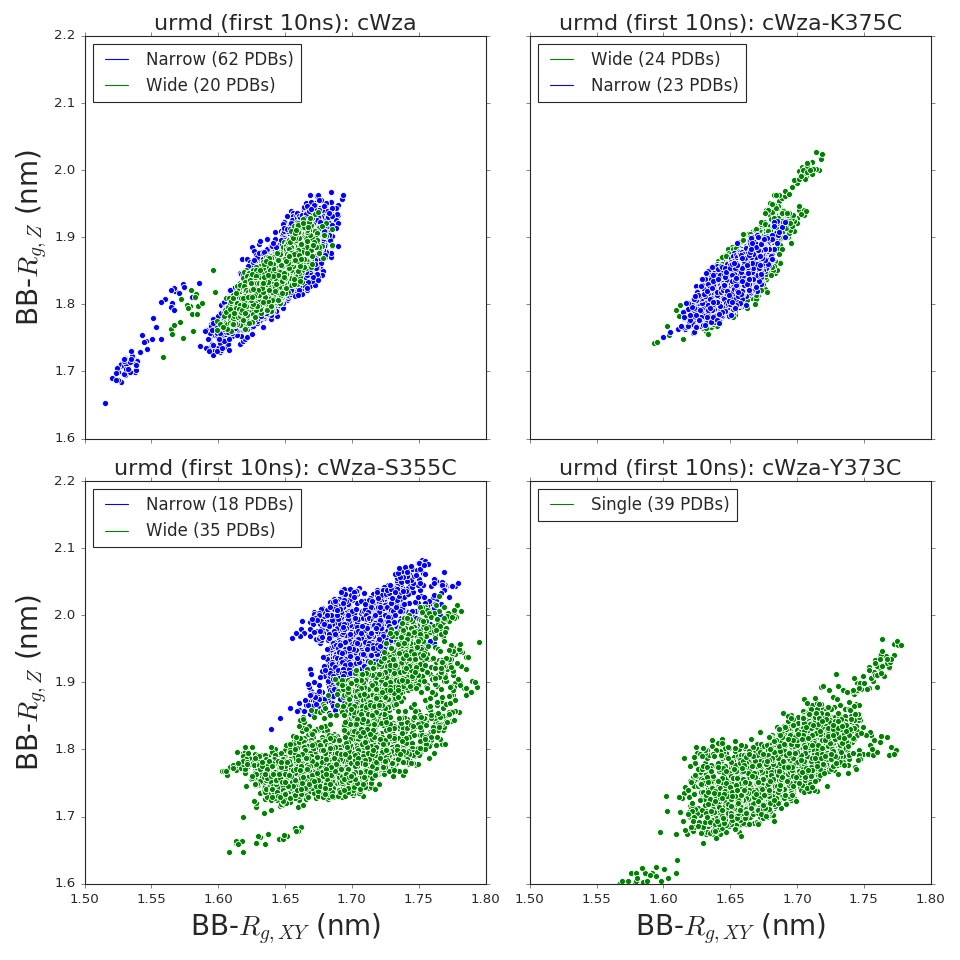

In [26]:
name = 'md_100ns'
atomic_group = 'Backbone'
ALL_First = []

fig, ax = plt.subplots(2,2,figsize=(12,12),sharex=True, sharey=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

Colors = {
    'cWza':{'Narrow':'blue', 'Wide':'green'},
    'cWza-K375C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-S355C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-Y373C':{'Single':'green'}
}

Conformations = {
    'cWza':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-K375C':{'conformation1':'Narrow', 'conformation0':'Wide'},
    'cWza-S355C':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-Y373C':{'conformation1':'Single'}
}

def filter_XY(filename):
    lines = open(filename,'r').readlines()
    return [list(map(float,xy.split())) for xy in lines if (not "#" in xy) and (not "@" in xy)]

for tag in MyTags:
    X_all = []; Y_all= []
    mutant, group = json.loads(tag)
    ############################################
    COUNTER_model = 0
    for n in range(len(refined_param_list)):
        if refined_param_list[n].split('/')[0] == mutant and refined_param_list[n].split('/')[1] == group:
            
            ############################################
            # Extract data 
            ############################################
            filename = wd+refined_param_list[n]+'/complex/mdf/'+name+'_gyrate_'+atomic_group+'.xvg'
            try:
                if os.path.isfile(filename):
                    COUNTER_model += 1
                    data = filter_XY(filename)[:-2]
                    data = numpy.array(data).T
                    if len(data) > 0:
                        Rg_x = data[2]; Rg_y = data[3]; Rg_z = data[4]
                        Rg_xy = (Rg_x + Rg_y)/float(2)
                        ############################################
                        # Scatter Plots
                        ############################################
                        X = Rg_xy[:100]; Y = Rg_z[:100]
                        X_all = X_all + list(X); Y_all = Y_all + list(Y)
                        mycolor = Colors[mutant][Conformations[mutant][group]]
                        sns.scatterplot(X,Y,color=mycolor,s=30, ax=axes[mutant])
            except:
                print("No Rg data for this model: ", refined_param_list[n])
    ALL_First.append([X_all, Y_all])
    ############################################
    # Add Legend Box
    ############################################
    axes[mutant].plot([],[],label=Conformations[mutant][group]+" ("+str(COUNTER_model)+" PDBs)",color=mycolor)
    ############################################
    # Customise plot
    ############################################
    axes[mutant].set_title("urmd (first 10ns): "+mutant, fontsize=20)
    axes[mutant].set_xlim(1.5,1.8)
    axes[mutant].set_ylim(1.6,2.2)
    axes[mutant].legend(loc='upper left',fontsize=15)

############################################
# More customisation
############################################
axes['cWza'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)
axes['cWza-Y373C'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


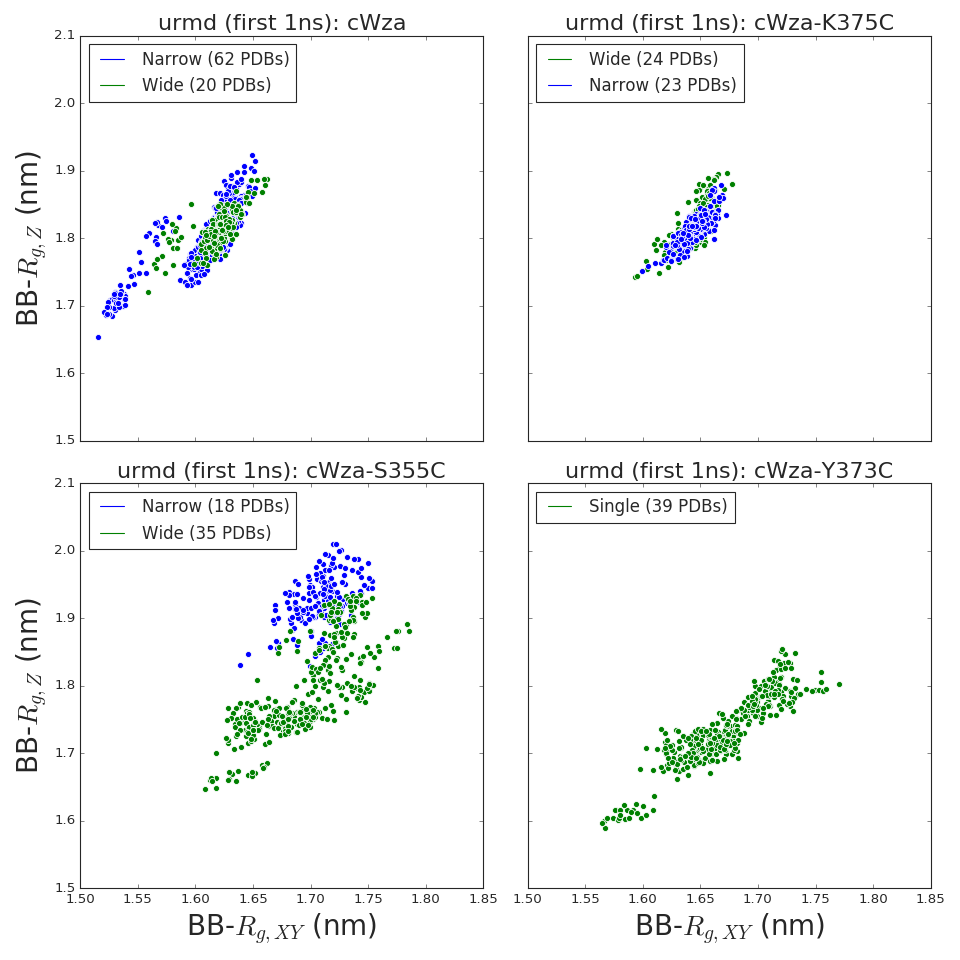

In [27]:
name = 'md_100ns'
atomic_group = 'Backbone'
# ALL_First = []

fig, ax = plt.subplots(2,2,figsize=(12,12),sharex=True, sharey=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

Colors = {
    'cWza':{'Narrow':'blue', 'Wide':'green'},
    'cWza-K375C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-S355C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-Y373C':{'Single':'green'}
}

Conformations = {
    'cWza':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-K375C':{'conformation1':'Narrow', 'conformation0':'Wide'},
    'cWza-S355C':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-Y373C':{'conformation1':'Single'}
}

def filter_XY(filename):
    lines = open(filename,'r').readlines()
    return [list(map(float,xy.split())) for xy in lines if (not "#" in xy) and (not "@" in xy)]

for tag in MyTags:
#     X_all = []; Y_all= []
    mutant, group = json.loads(tag)
    ############################################
    COUNTER_model = 0
    for n in range(len(refined_param_list)):
        if refined_param_list[n].split('/')[0] == mutant and refined_param_list[n].split('/')[1] == group:
            COUNTER_model += 1
            ############################################
            # Extract data 
            ############################################
            filename = wd+refined_param_list[n]+'/complex/mdf/'+name+'_gyrate_'+atomic_group+'.xvg'
            if os.path.isfile(filename):
                data = filter_XY(filename)[:-2]
                data = numpy.array(data).T
                if len(data) > 0:
                    Rg_x = data[2]; Rg_y = data[3]; Rg_z = data[4]
                    Rg_xy = (Rg_x + Rg_y)/float(2)
                    ############################################
                    # Scatter Plots
                    ############################################
                    X = Rg_xy[:10]; Y = Rg_z[:10]
    #                 X_all = X_all + list(X); Y_all = Y_all + list(Y)
                    mycolor = Colors[mutant][Conformations[mutant][group]]
                    sns.scatterplot(X,Y,color=mycolor,s=30, ax=axes[mutant])
#     ALL_First.append([X_all, Y_all])
    ############################################
    # Add Legend Box
    ############################################
    axes[mutant].plot([],[],label=Conformations[mutant][group]+" ("+str(COUNTER_model)+" PDBs)",color=mycolor)
    ############################################
    # Customise plot
    ############################################
    axes[mutant].set_title("urmd (first 1ns): "+mutant, fontsize=20)
#     axes[mutant].set_xlim(1.5,1.8)
#     axes[mutant].set_ylim(1.6,2.2)
    axes[mutant].legend(loc='upper left',fontsize=15)

############################################
# More customisation
############################################
axes['cWza'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)
axes['cWza-Y373C'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)

fig.tight_layout()
plt.show()

### Raw Data: Last 10 ns

<IPython.core.display.Javascript object>


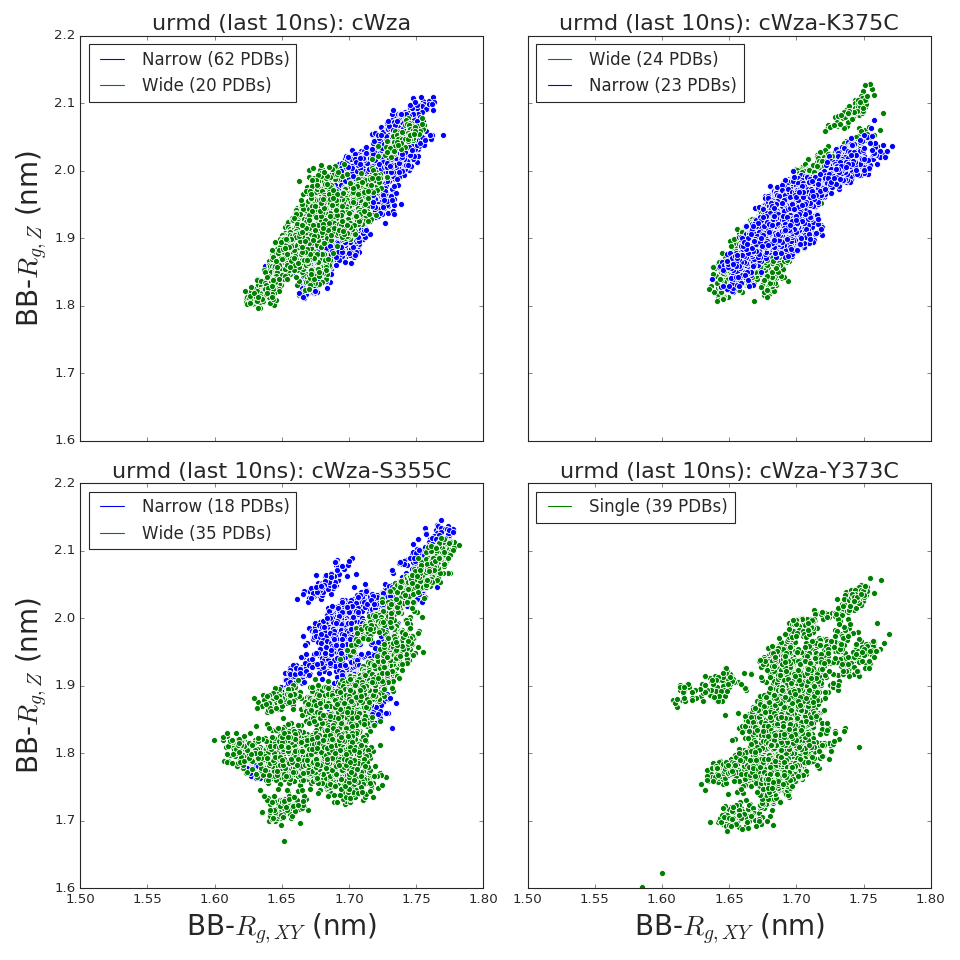

In [28]:
name = 'md_100ns'
atomic_group = 'Backbone'
ALL_Last = []

fig, ax = plt.subplots(2,2,figsize=(12,12),sharex=True, sharey=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

Colors = {
    'cWza':{'Narrow':'blue', 'Wide':'green'},
    'cWza-K375C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-S355C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-Y373C':{'Single':'green'}
}

Conformations = {
    'cWza':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-K375C':{'conformation1':'Narrow', 'conformation0':'Wide'},
    'cWza-S355C':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-Y373C':{'conformation1':'Single'}
}

def filter_XY(filename):
    lines = open(filename,'r').readlines()
    return [list(map(float,xy.split())) for xy in lines if (not "#" in xy) and (not "@" in xy)]

for tag in MyTags:
    X_all = []; Y_all= []
    mutant, group = json.loads(tag)
    ############################################
    COUNTER_model = 0
    for n in range(len(refined_param_list)):
        if refined_param_list[n].split('/')[0] == mutant and refined_param_list[n].split('/')[1] == group:
            COUNTER_model += 1
            ############################################
            # Extract data 
            ############################################
            filename = wd+refined_param_list[n]+'/complex/mdf/'+name+'_gyrate_'+atomic_group+'.xvg'
            if os.path.isfile(filename):
                data = filter_XY(filename)[:-2]
                data = numpy.array(data).T
                if len(data) > 0:
                    Rg_x = data[2]; Rg_y = data[3]; Rg_z = data[4]
                    Rg_xy = (Rg_x + Rg_y)/float(2)
                    ############################################
                    # Scatter Plots
                    ############################################
                    X = Rg_xy[-100:]; Y = Rg_z[-100:]
                    X_all = X_all + list(X); Y_all = Y_all + list(Y)
                    mycolor = Colors[mutant][Conformations[mutant][group]]
                    sns.scatterplot(X,Y,color=mycolor,s=30, ax=axes[mutant])
    ALL_Last.append([X_all, Y_all])
    ############################################
    # Add Legend Box
    ############################################
    axes[mutant].plot([],[],label=Conformations[mutant][group]+" ("+str(COUNTER_model)+" PDBs)",color=mycolor)
    ############################################
    # Customise plot
    ############################################
    axes[mutant].set_title("urmd (last 10ns): "+mutant, fontsize=20)
    axes[mutant].set_xlim(1.5,1.8)
    axes[mutant].set_ylim(1.6,2.2)
    axes[mutant].legend(loc='upper left',fontsize=15)

############################################
# More customisation
############################################
axes['cWza'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)
axes['cWza-Y373C'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)

fig.tight_layout()
plt.show()

### Contour Plots Per Trajectory: First 10ns

<IPython.core.display.Javascript object>


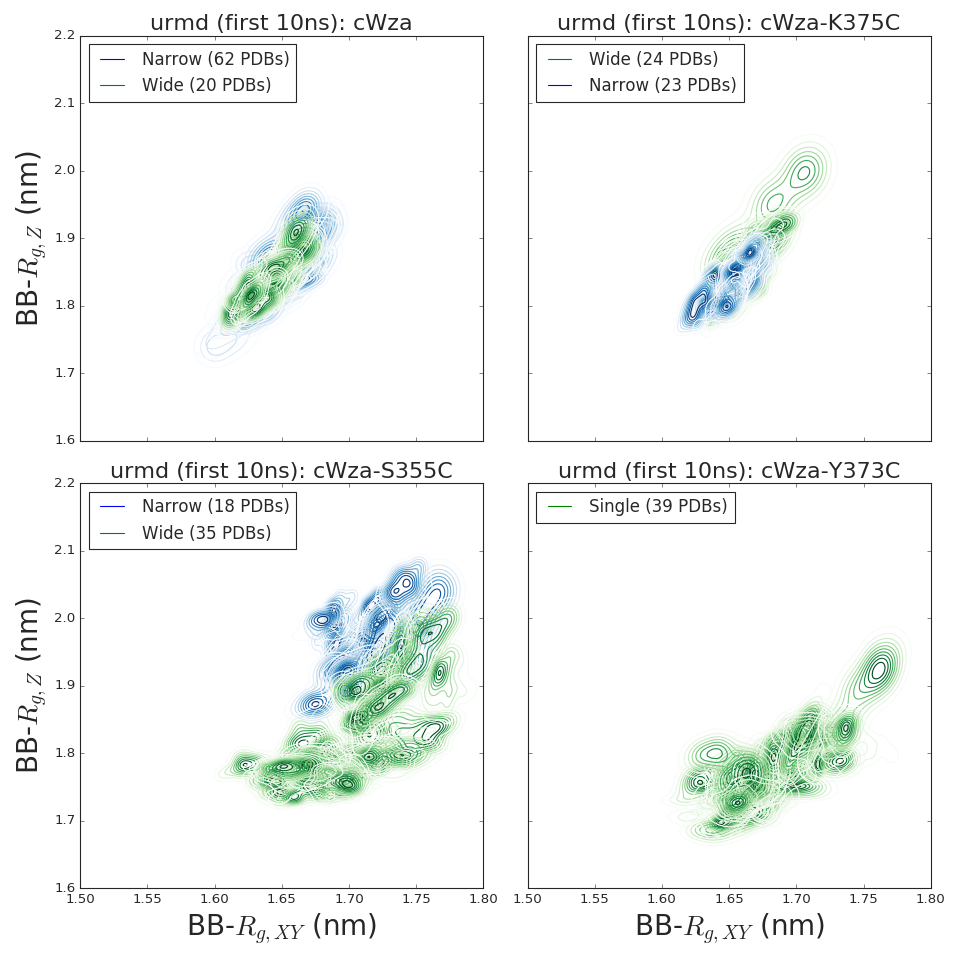

In [29]:
name = 'md_100ns'
atomic_group = 'Backbone'

fig, ax = plt.subplots(2,2,figsize=(12,12),sharex=True, sharey=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

CMaps = {
    'cWza':{'Narrow':'Blues', 'Wide':'Greens'},
    'cWza-K375C':{'Narrow':'Blues', 'Wide':'Greens'},
    'cWza-S355C':{'Narrow':'Blues', 'Wide':'Greens'},
    'cWza-Y373C':{'Single':'Greens'}
}

Colors = {
    'cWza':{'Narrow':'blue', 'Wide':'green'},
    'cWza-K375C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-S355C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-Y373C':{'Single':'green'}
}

Conformations = {
    'cWza':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-K375C':{'conformation1':'Narrow', 'conformation0':'Wide'},
    'cWza-S355C':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-Y373C':{'conformation1':'Single'}
}

def filter_XY(filename):
    lines = open(filename,'r').readlines()
    return [list(map(float,xy.split())) for xy in lines if (not "#" in xy) and (not "@" in xy)]

for tag in MyTags:
    mutant, group = json.loads(tag)
    ############################################
    COUNTER_model = 0
    for n in range(len(refined_param_list)):
        if refined_param_list[n].split('/')[0] == mutant and refined_param_list[n].split('/')[1] == group:
            COUNTER_model += 1
            ############################################
            # Extract data 
            ############################################
            filename = wd+refined_param_list[n]+'/complex/mdf/'+name+'_gyrate_'+atomic_group+'.xvg'
            if os.path.isfile(filename):
                data = filter_XY(filename)[:-2]
                data = numpy.array(data).T
                if len(data) > 0:
                    Rg_x = data[2]; Rg_y = data[3]; Rg_z = data[4]
                    Rg_xy = (Rg_x + Rg_y)/float(2)
                    ############################################
                    # Scatter Plots
                    ############################################
                    X = Rg_xy[:100]; Y = Rg_z[:100]
                    mycmap = CMaps[mutant][Conformations[mutant][group]]
                    sns.kdeplot(X,Y,n_levels=10, cmap=mycmap, ax= axes[mutant])
    ############################################
    # Add Legend Box
    ############################################
    mycolor = Colors[mutant][Conformations[mutant][group]]
    axes[mutant].plot([],[],label=Conformations[mutant][group]+" ("+str(COUNTER_model)+" PDBs)",color=mycolor)
    ############################################
    # Customise plot
    ############################################
    axes[mutant].set_title("urmd (first 10ns): "+mutant, fontsize=20)
    axes[mutant].set_xlim(1.5,1.8)
    axes[mutant].set_ylim(1.6,2.2)
    axes[mutant].legend(loc='upper left',fontsize=15)

############################################
# More customisation
############################################
axes['cWza'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)
axes['cWza-Y373C'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)

fig.tight_layout()
plt.show()

### Contour Plots Per Trajectory: Last 10ns

<IPython.core.display.Javascript object>


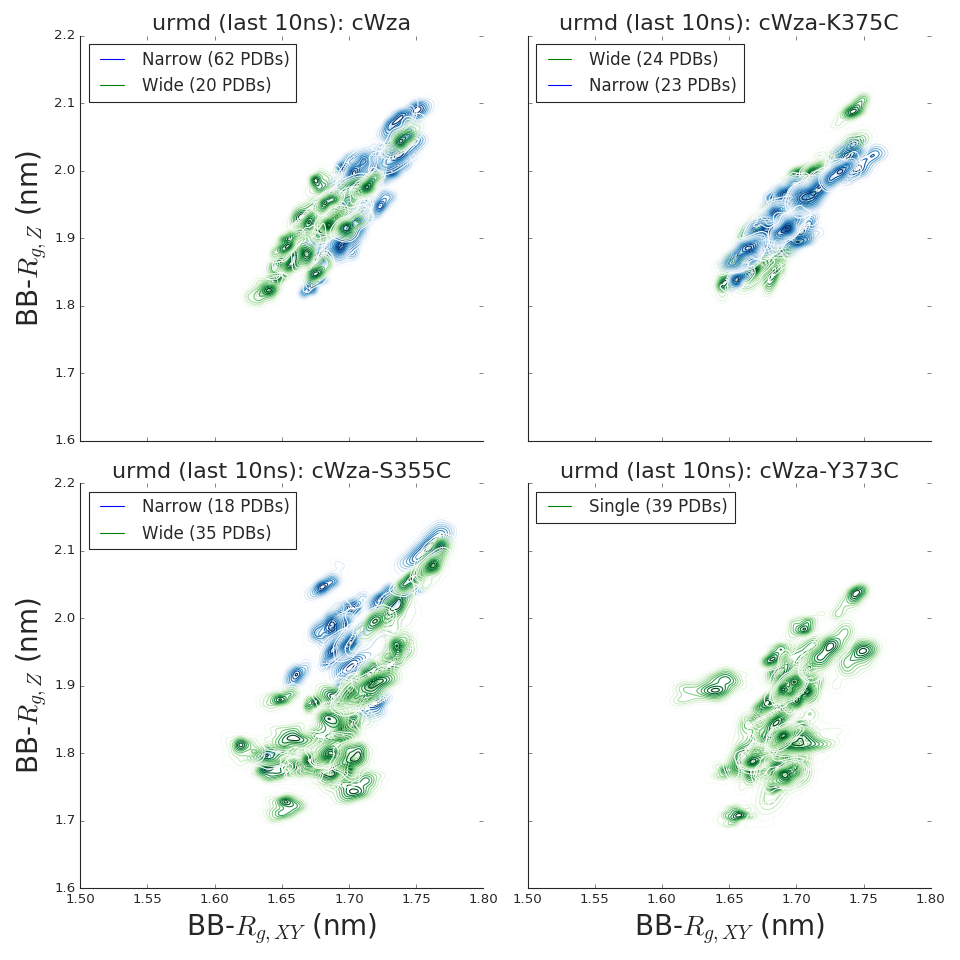

In [30]:
name = 'md_100ns'
atomic_group = 'Backbone'

fig, ax = plt.subplots(2,2,figsize=(12,12),sharex=True, sharey=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

CMaps = {
    'cWza':{'Narrow':'Blues', 'Wide':'Greens'},
    'cWza-K375C':{'Narrow':'Blues', 'Wide':'Greens'},
    'cWza-S355C':{'Narrow':'Blues', 'Wide':'Greens'},
    'cWza-Y373C':{'Single':'Greens'}
}

Colors = {
    'cWza':{'Narrow':'blue', 'Wide':'green'},
    'cWza-K375C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-S355C':{'Narrow':'blue', 'Wide':'green'},
    'cWza-Y373C':{'Single':'green'}
}

Conformations = {
    'cWza':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-K375C':{'conformation1':'Narrow', 'conformation0':'Wide'},
    'cWza-S355C':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-Y373C':{'conformation1':'Single'}
}

def filter_XY(filename):
    lines = open(filename,'r').readlines()
    return [list(map(float,xy.split())) for xy in lines if (not "#" in xy) and (not "@" in xy)]

for tag in MyTags:
    mutant, group = json.loads(tag)
    ############################################
    COUNTER_model = 0
    for n in range(len(refined_param_list)):
        if refined_param_list[n].split('/')[0] == mutant and refined_param_list[n].split('/')[1] == group:
            COUNTER_model += 1
            ############################################
            # Extract data 
            ############################################
            filename = wd+refined_param_list[n]+'/complex/mdf/'+name+'_gyrate_'+atomic_group+'.xvg'
            if os.path.isfile(filename):
                data = filter_XY(filename)[:-2]
                data = numpy.array(data).T
                if len(data) > 0:
                    Rg_x = data[2]; Rg_y = data[3]; Rg_z = data[4]
                    Rg_xy = (Rg_x + Rg_y)/float(2)
                    ############################################
                    # Scatter Plots
                    ############################################
                    X = Rg_xy[-100:]; Y = Rg_z[-100:]
                    mycmap = CMaps[mutant][Conformations[mutant][group]]
                    sns.kdeplot(X,Y,n_levels=10, cmap=mycmap, ax= axes[mutant])
    ############################################
    # Add Legend Box
    ############################################
    mycolor = Colors[mutant][Conformations[mutant][group]]
    axes[mutant].plot([],[],label=Conformations[mutant][group]+" ("+str(COUNTER_model)+" PDBs)",color=mycolor)
    ############################################
    # Customise plot
    ############################################
    axes[mutant].set_title("urmd (last 10ns): "+mutant, fontsize=20)
    axes[mutant].set_xlim(1.5,1.8)
    axes[mutant].set_ylim(1.6,2.2)
    axes[mutant].legend(loc='upper left',fontsize=15)

############################################
# More customisation
############################################
axes['cWza'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)
axes['cWza-Y373C'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)

fig.tight_layout()
plt.show()

### Contour Plots Merged Trajectories: First 10ns

<IPython.core.display.Javascript object>


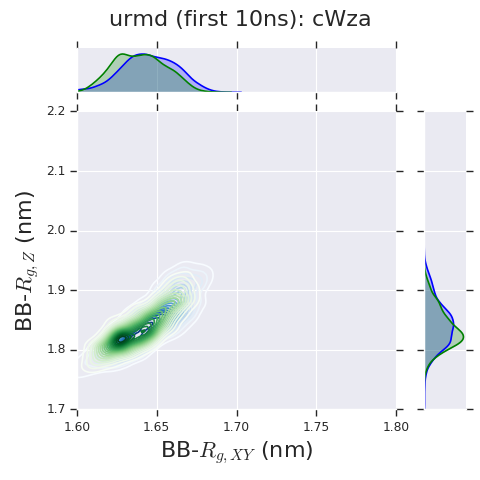

<IPython.core.display.Javascript object>


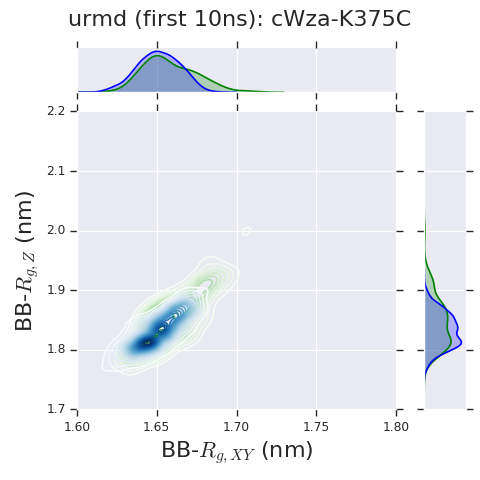

<IPython.core.display.Javascript object>


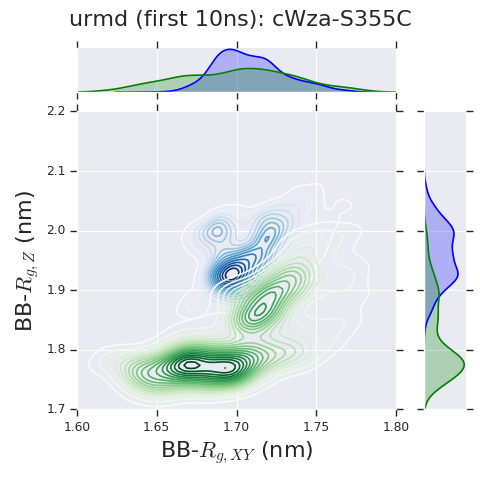

<IPython.core.display.Javascript object>


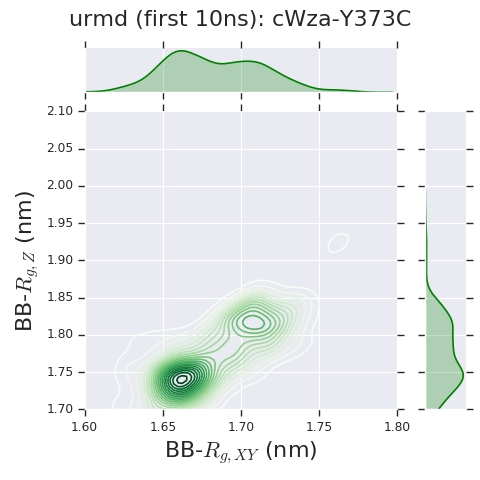

In [31]:

CMaps = {
    'cWza':['Blues', 'Greens'],
    'cWza-K375C':['Greens', 'Blues'],
    'cWza-S355C':['Blues', 'Greens'],
    'cWza-Y373C':['Greens'],
}

Colors = {
    'cWza':['blue', 'green'],
    'cWza-K375C':['green', 'blue'],
    'cWza-S355C':['blue', 'green'],
    'cWza-Y373C':['green'],    
}

for i in range(len(mutant_names)):
    sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})
    mutant = mutant_names[i]
    if mutant != 'cWza-Y373C':
        X0,Y0 = ALL_First[2*i]
        X1,Y1 = ALL_First[2*i+1]

        df0 = pd.DataFrame({'x':X0, 'y':Y0})
        df1 = pd.DataFrame({'x':X1, 'y':Y1})
        DFs = [df0, df1]

        sns.set(style="darkgrid")
        sns.despine()

        g = sns.JointGrid(
            x="x", 
            y="y", 
            height=6,
            space=0,
            xlim=(1.6,1.8),
            ylim=(1.7,2.2),
            data=pd.concat(DFs, axis=1, join='inner')
            )
    else:
        X,Y = ALL_First[-1]
        DFs = [pd.DataFrame({'x':X, 'y':Y})] 
        
        sns.set(style="darkgrid")
        sns.despine()

        g = sns.JointGrid(
            x="x", 
            y="y", 
            height=6,
            space=0,
            xlim=(1.6,1.8),
            ylim=(1.7,2.1),
            data=DFs[0]
        )

    # Contour plots
    for k in range(len(DFs)):
        df = DFs[k]
        # Heatmaps
        sns.kdeplot(df.x, df.y, cmap=CMaps[mutant][k], n_levels=20, ax=g.ax_joint)        
        # Histograms
        sns.kdeplot(df.x, color=Colors[mutant][k], shade=True, legend=False ,ax=g.ax_marg_x)
        sns.kdeplot(df.y, color=Colors[mutant][k], shade=True, legend=False ,ax=g.ax_marg_y,vertical=True)

    # Further curtomization
    g.fig.suptitle("urmd (first 10ns): "+mutant, fontsize=20)
    g.set_axis_labels("BB-$R_{g, XY}$ (nm)","BB-$R_{g, Z}$ (nm)",fontsize=20)
    g.fig.tight_layout()

    plt.subplots_adjust(top=0.9)
    plt.show()

### Contour Plots Merged Trajectories: Last 10ns

<IPython.core.display.Javascript object>


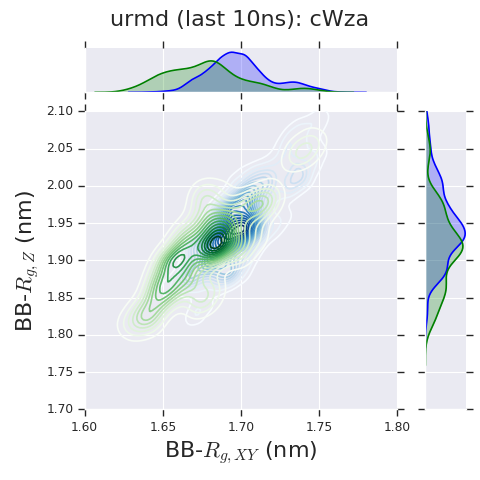

<IPython.core.display.Javascript object>


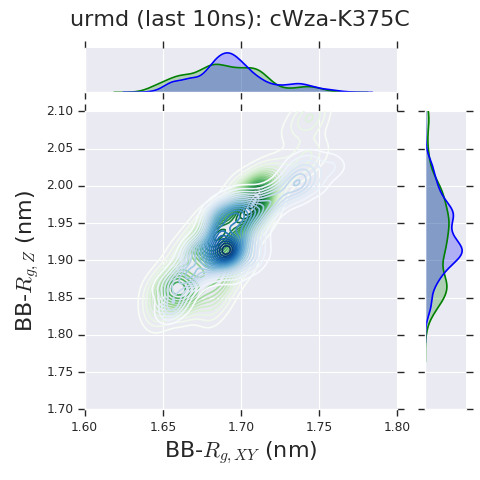

<IPython.core.display.Javascript object>


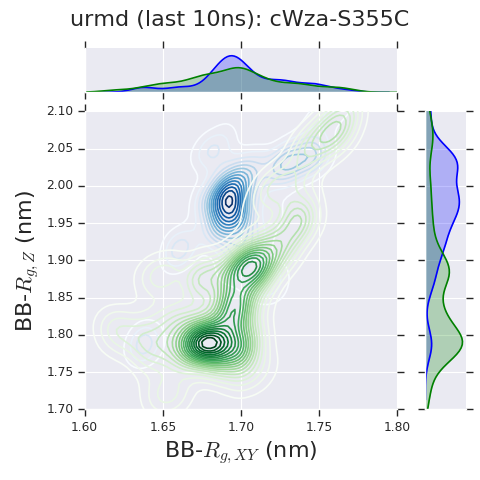

<IPython.core.display.Javascript object>


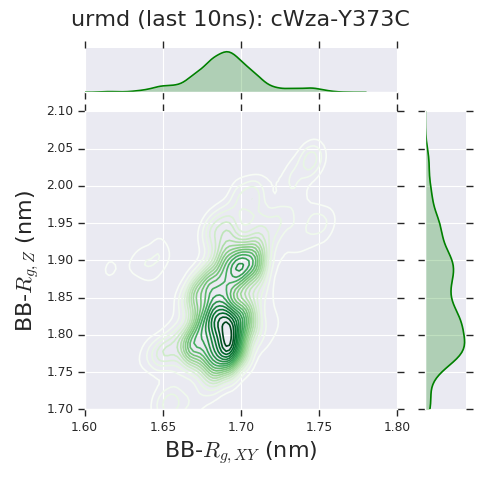

In [32]:

CMaps = {
    'cWza':['Blues', 'Greens'],
    'cWza-K375C':['Greens', 'Blues'],
    'cWza-S355C':['Blues', 'Greens'],
    'cWza-Y373C':['Greens'],
}

Colors = {
    'cWza':['blue', 'green'],
    'cWza-K375C':['green', 'blue'],
    'cWza-S355C':['blue', 'green'],
    'cWza-Y373C':['green'],    
}

for i in range(len(mutant_names)):
    sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})
    mutant = mutant_names[i]
    if mutant != 'cWza-Y373C':
        X0,Y0 = ALL_Last[2*i]
        X1,Y1 = ALL_Last[2*i+1]

        df0 = pd.DataFrame({'x':X0, 'y':Y0})
        df1 = pd.DataFrame({'x':X1, 'y':Y1})
        DFs = [df0, df1]

        sns.set(style="darkgrid")
        sns.despine()

        g = sns.JointGrid(
            x="x", 
            y="y", 
            height=6,
            space=0,
            xlim=(1.6,1.8),
            ylim=(1.7,2.1),
            data=pd.concat(DFs, axis=1, join='inner')
            )
    else:
        X,Y = ALL_Last[-1]
        DFs = [pd.DataFrame({'x':X, 'y':Y})] 
        
        sns.set(style="darkgrid")
        sns.despine()

        g = sns.JointGrid(
            x="x", 
            y="y", 
            height=6,
            space=0,
            xlim=(1.6,1.8),
            ylim=(1.7,2.1),
            data=DFs[0]
        )

    # Contour plots
    for k in range(len(DFs)):
        df = DFs[k]
        # Heatmaps
        sns.kdeplot(df.x, df.y, cmap=CMaps[mutant][k], n_levels=20, ax=g.ax_joint)        
        # Histograms
        sns.kdeplot(df.x, color=Colors[mutant][k], shade=True, legend=False ,ax=g.ax_marg_x)
        sns.kdeplot(df.y, color=Colors[mutant][k], shade=True, legend=False ,ax=g.ax_marg_y,vertical=True)

    # Further curtomization
    g.fig.suptitle("urmd (last 10ns): "+mutant, fontsize=20)
    g.set_axis_labels("BB-$R_{g, XY}$ (nm)","BB-$R_{g, Z}$ (nm)",fontsize=20)
    g.fig.tight_layout()

    plt.subplots_adjust(top=0.9)
    plt.show()

### Contour Plots Merged Trajectories-Conformations: First 10ns

<IPython.core.display.Javascript object>


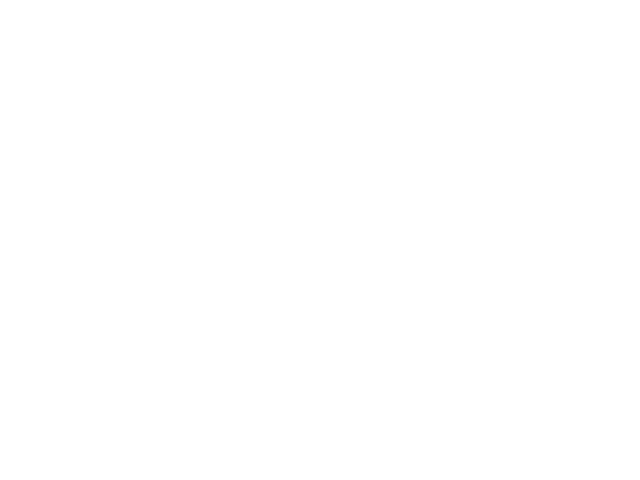

<IPython.core.display.Javascript object>


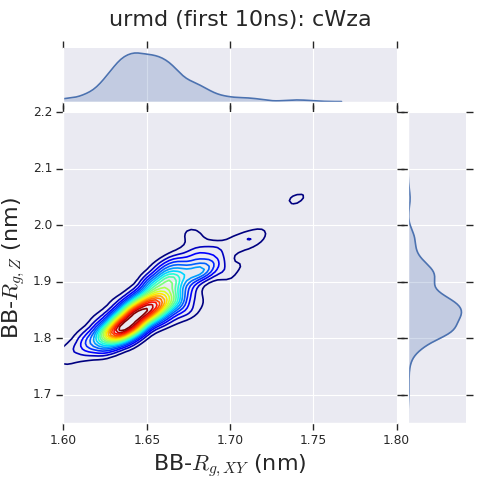

<IPython.core.display.Javascript object>


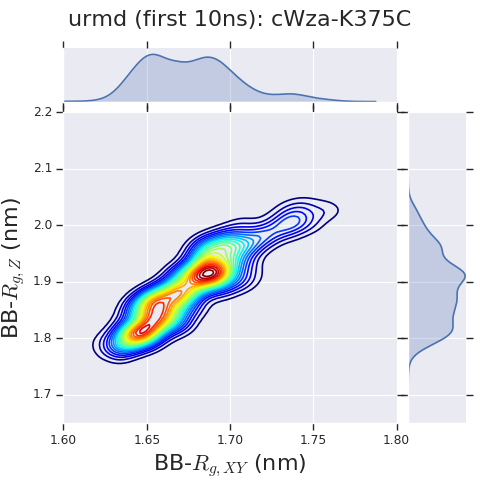

<IPython.core.display.Javascript object>


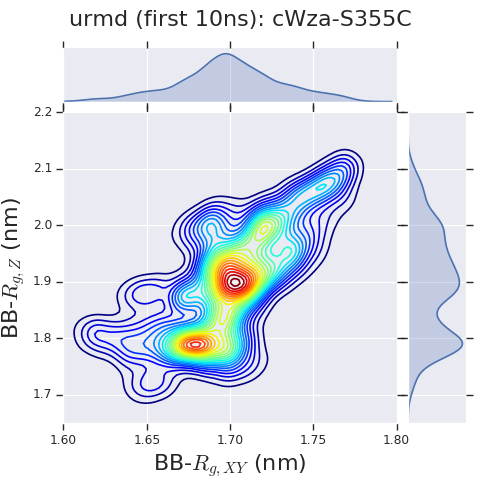

<IPython.core.display.Javascript object>


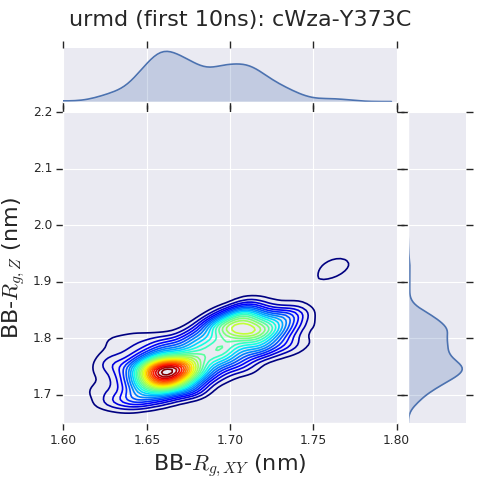

In [69]:

for i in range(len(mutant_names)):
    sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})
    mutant = mutant_names[i]
    if mutant != 'cWza-Y373C':
        X = ALL_First[2*i][0] + ALL_Last[2*i+1][0]
        Y = ALL_First[2*i][1] + ALL_Last[2*i+1][1]
        df = pd.DataFrame({'x':X, 'y':Y})
        sns.set(style="darkgrid")
        sns.despine()
        g = sns.jointplot(df.x, df.y, cmap='jet',kind='kde',shade=False,n_levels=25,xlim=(1.6,1.8),ylim=(1.65,2.2))

    else:
        X,Y = ALL_First[-1]
        df = pd.DataFrame({'x':X, 'y':Y})
        sns.set(style="darkgrid")
        sns.despine()
        g = sns.jointplot(df.x, df.y, cmap='jet',kind='kde',shade=False,n_levels=25,xlim=(1.6,1.8),ylim=(1.65,2.2))
        
    # Further curtomization
    g.fig.suptitle("urmd (first 10ns): "+mutant, fontsize=20)
    g.set_axis_labels("BB-$R_{g, XY}$ (nm)","BB-$R_{g, Z}$ (nm)",fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

### Contour Plots Merged Trajectories-Conformations: Last 10ns

<IPython.core.display.Javascript object>


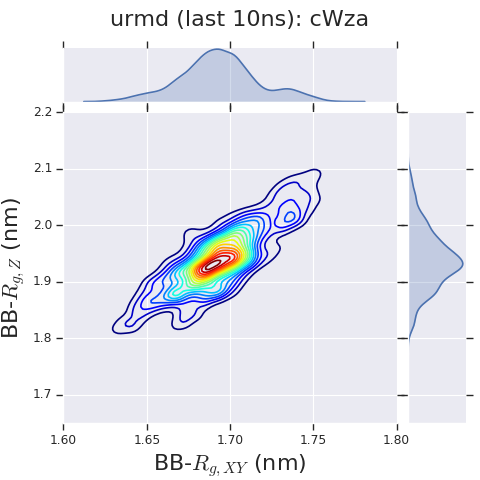

<IPython.core.display.Javascript object>


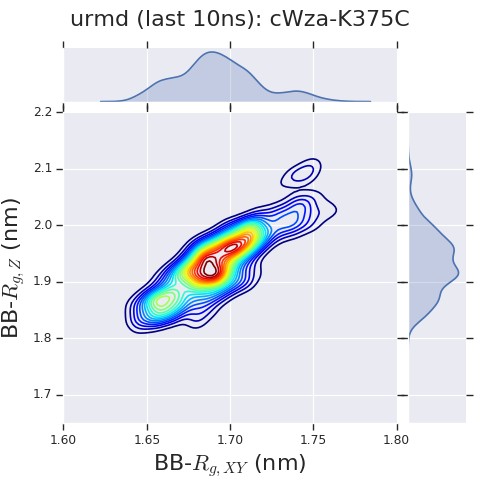

<IPython.core.display.Javascript object>


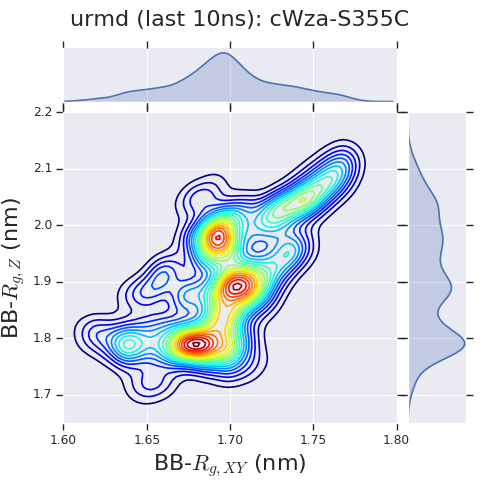

<IPython.core.display.Javascript object>


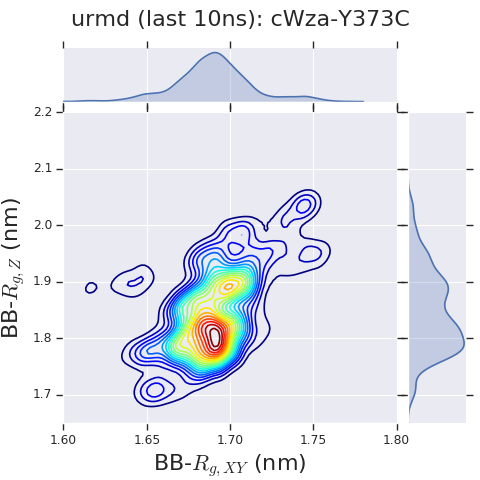

In [67]:
for i in range(len(mutant_names)):
    sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})
    mutant = mutant_names[i]
    if mutant != 'cWza-Y373C':
        X = ALL_Last[2*i][0] + ALL_Last[2*i+1][0]
        Y = ALL_Last[2*i][1] + ALL_Last[2*i+1][1]
        df = pd.DataFrame({'x':X, 'y':Y})
        sns.set(style="darkgrid")
        sns.despine()
        g = sns.jointplot(df.x, df.y, cmap='jet',kind='kde',shade=False,n_levels=25,xlim=(1.6,1.8),ylim=(1.65,2.2))

    else:
        X,Y = ALL_Last[-1]
        df = pd.DataFrame({'x':X, 'y':Y})
        sns.set(style="darkgrid")
        sns.despine()
        g = sns.jointplot(df.x, df.y, cmap='jet',kind='kde',shade=False,n_levels=25,xlim=(1.6,1.8),ylim=(1.65,2.2))
        
    # Further curtomization
    g.fig.suptitle("urmd (last 10ns): "+mutant, fontsize=20)
    g.set_axis_labels("BB-$R_{g, XY}$ (nm)","BB-$R_{g, Z}$ (nm)",fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()


## Interaction Partitions 

### Break Down of Trajectories by Starting Interactions

In [ ]:
name = 'md_100ns'
atomic_group = 'Backbone'
filename = name+'_gyrate_'+atomic_group+'.xvg'

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

for tag in MyTags:
    mutant, conformation = json.loads(tag)

    # Correct tags
    if mutant == 'cWza-Y373C':
        tag = json.dumps([mutant,'conformation0'])
    elif mutant == 'cWza-K375C' and conformation=='conformation0':
        conformation = 'conformation1'
    elif mutant == 'cWza-K375C' and conformation=='conformation1':
        conformation = 'conformation0'     


    fig, ax = plt.subplots(2,2, figsize=(12,12),dpi=200,sharex=True, sharey=True)
    sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})
    axes = {
        'hbonds_NOT_kihs':ax[0,0],
        'kihs_NOT_hbonds':ax[0,1],
        'hbonds_AND_kihs':ax[1,0],
        'hbonds_NOR_kihs':ax[1,1]
    }

    Keys = ['hbonds_NOT_kihs', 'kihs_NOT_hbonds', 'hbonds_AND_kihs', 'hbonds_NOR_kihs']

    Colors = {
        'hbonds_NOT_kihs':'red',
        'kihs_NOT_hbonds':'black',
        'hbonds_AND_kihs':'orange',
        'hbonds_NOR_kihs':'magenta'
    }

    for key in Keys:
        X = PARTITIONS[tag][key]
        for pdb_name in X:
            modeldir = mutant+'/'+conformation+'/'+pdb_name
            file_path = wd+modeldir+'/complex/mdf/'+filename
            if os.path.isfile(file_path):
                data = filter_XY(file_path)[:-2]
                data = numpy.array(data).T
                if len(data) > 0:
                    Rg_x = data[2]; Rg_y = data[3]; Rg_z = data[4]
                    Rg_xy = (Rg_x + Rg_y)/float(2)
                    ############################################
                    # Scatter Plots
                    ############################################
                    X = Rg_xy[-100:]; Y = Rg_z[-100:]
                    mycmap = sns.light_palette(Colors[key], as_cmap=True)
                    sns.kdeplot(X, Y, cmap=mycmap, n_levels=10 , ax=axes[key])
        ############################################
        # Customise plot
        ############################################
        axes[key].plot([],[],label=" ".join(key.split("_")),color=Colors[key])
        C_n = conformation[-1]
        if mutant == 'cWza-K375C' and C_n == str(0):
            C_n = str(1)
        elif mutant == 'cWza-K375C' and C_n == str(1):
            C_n = str(0)
        axes[key].set_title("urmd (last 10ns): "+mutant+': C'+C_n, fontsize=20)
        axes[key].set_xlim(1.6,1.8)
        axes[key].set_ylim(1.7,2.1)
        axes[key].legend(loc='upper left',fontsize=15)

    ############################################
    # More customisation
    ############################################
    axes['hbonds_NOT_kihs'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
    axes['hbonds_AND_kihs'].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
    axes['hbonds_AND_kihs'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)
    axes['hbonds_NOR_kihs'].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)

    fig.tight_layout()
    plt.show()   

### Break Down of Merged Data by Starting Interactions

In [ ]:
mutant = "cWza-K375C"
conformation = "conformation0"
C = 0
for n in range(len(refined_param_list)):
    if mutant in refined_param_list[n] and conformation in refined_param_list[n]:
        file_path = wd+refined_param_list[n]+'/complex/mdf/'+name+'_gyrate_'+atomic_group+'.xvg'
        if os.path.isfile(file_path):
            C +=1 

In [ ]:
C

In [ ]:
PDB_part

In [ ]:
name = 'md_100ns'
atomic_group = 'Backbone'
filename = name+'_gyrate_'+atomic_group+'.xvg'

PARTITIONS['["cWza-K375C", "conformation1"]']
mutant = "cWza-K375C"
conformation = "conformation1"

PDB_part = 0

for key in Keys:
    for pdb_name in PARTITIONS['["cWza-K375C", "conformation1"]'][key]:
        conformation = "conformation0"
        modeldir = mutant+'/'+conformation+'/'+pdb_name
        file_path = wd+modeldir+'/complex/mdf/'+filename
        if os.path.isfile(file_path):
            print(key, pdb_name, True)
            PDB_part += 1
        else:
            print(key, pdb_name, False)


In [ ]:
name = 'md_100ns'
atomic_group = 'Backbone'
filename = name+'_gyrate_'+atomic_group+'.xvg'

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

sns.set_style("darkgrid",{"xtick.direction": "in","ytick.direction": "in",'axes.spines.right': True})



for i in range(len(MyTags)):
    fig, ax = plt.subplots(1,2,figsize=(12,6),dpi=150)
    X_all = []; Y_all = []
    tag = MyTags[i]
    mutant, conformation = json.loads(tag)
    # Correct tags
    if mutant == 'cWza-Y373C':
        tag = json.dumps([mutant,'conformation0'])

    Keys = ['hbonds_AND_kihs','hbonds_NOT_kihs', 'kihs_NOT_hbonds','hbonds_NOR_kihs']

    Colors = {
        'hbonds_NOT_kihs':'red',
        'kihs_NOT_hbonds':'black',
        'hbonds_AND_kihs':'orange',
        'hbonds_NOR_kihs':'magenta'
        }

    CMaps = {
    json.dumps(['cWza', 'conformation0']):'Blues',
    json.dumps(['cWza', 'conformation1']): 'Greens',
    json.dumps(['cWza-K375C', 'conformation0']): 'Blues',
    json.dumps(['cWza-K375C', 'conformation1']): 'Greens',
    json.dumps(['cWza-S355C', 'conformation0']): 'Blues',
    json.dumps(['cWza-S355C', 'conformation1']): 'Greens',
    json.dumps(['cWza-Y373C', 'conformation0']): 'Greens'
        }
    
    for key in Keys:
        XX = []; YY = []
        X = PARTITIONS[tag][key]
        for pdb_name in X:
            if mutant == 'cWza-K375C' and conformation=='conformation0':
                conformation = 'conformation1'
            elif mutant == 'cWza-K375C' and conformation=='conformation1':
                conformation = 'conformation0'   
            modeldir = mutant+'/'+conformation+'/'+pdb_name
            file_path = wd+modeldir+'/complex/mdf/'+filename
            if os.path.isfile(file_path):
                data = filter_XY(file_path)[:-2]
                data = numpy.array(data).T
                if len(data) > 0:
                    Rg_x = data[2]; Rg_y = data[3]; Rg_z = data[4]
                    Rg_xy = (Rg_x + Rg_y)/float(2)
                    ############################################
                    # Scatter Plots
                    ############################################
                    X = Rg_xy[-100:]; Y = Rg_z[-100:]
                    XX = XX + list(X); YY = YY + list(Y)
        X_all = X_all + list(XX); Y_all = Y_all + list(YY)
        mycmap = sns.light_palette(Colors[key], as_cmap=True)
        sns.kdeplot(XX, YY, cmap=mycmap, n_levels=20 , ax=ax[1])
        ############################################
        # Customise plot
        ############################################
        ax[1].plot([],[],label=" ".join(key.split("_")),color=Colors[key])
        ax[1].text(1.72,1.8, "Interaction Groups")
        ax[1].set_title("Starting Interactions (docking)", fontsize=20)
        ax[1].set_xlim(1.6,1.8)
        ax[1].set_ylim(1.7,2.1)
        ax[1].legend(loc='lower right',fontsize=12)
    sns.kdeplot(X_all, Y_all, cmap=CMaps[tag], n_levels=20 , ax=ax[0])
    C_n = conformation[-1]
#     if mutant == 'cWza-K375C' and C_n == str(0):
#         C_n = str(1)
#     elif mutant == 'cWza-K375C' and C_n == str(1):
#         C_n = str(0)
    ax[0].set_title("urmd (last 10ns): "+mutant+': C'+C_n, fontsize=20)
    ax[0].set_xlim(1.6,1.8)
    ax[0].set_ylim(1.7,2.1)
    ############################################
    # More customisation
    ############################################
    for j in range(2):
        ax[j].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
        ax[j].set_ylabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
        ax[j].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)
        ax[j].set_xlabel("BB-$R_{g, XY}$ (nm)",fontsize=25)

    fig.tight_layout()

plt.show()   

# APPENDIX

## Hexagonal Maps

In [ ]:
name = 'md_100ns'
atomic_group = 'Backbone'

fig, ax = plt.subplots(2,2,figsize=(12,12),sharex=True, sharey=True)

sns.set_style("darkgrid")

MyTags  = [
    json.dumps(['cWza', 'conformation0']),
    json.dumps(['cWza', 'conformation1']),
    json.dumps(['cWza-K375C', 'conformation0']),
    json.dumps(['cWza-K375C', 'conformation1']),
    json.dumps(['cWza-S355C', 'conformation0']),
    json.dumps(['cWza-S355C', 'conformation1']),
    json.dumps(['cWza-Y373C', 'conformation1'])
]

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

Colors = {
    'cWza':{'Narrow':'Blues', 'Wide':'Greens'},
    'cWza-K375C':{'Narrow':'Blues', 'Wide':'Greens'},
    'cWza-S355C':{'Narrow':'Blues', 'Wide':'Greens'},
    'cWza-Y373C':{'Single':'Greens'}
}

Conformations = {
    'cWza':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-K375C':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-S355C':{'conformation0':'Narrow', 'conformation1':'Wide'},
    'cWza-Y373C':{'conformation1':'Single'}
}

def filter_XY(filename):
    lines = open(filename,'r').readlines()
    return [list(map(float,xy.split())) for xy in lines if (not "#" in xy) and (not "@" in xy)]

for tag in MyTags:
    mutant, group = json.loads(tag)
    ############################################
    COUNTER_model = 0
#     for n in range(5):
    for n in range(len(refined_param_list)):
        if refined_param_list[n].split('/')[0] == mutant and refined_param_list[n].split('/')[1] == group:
            COUNTER_model += 1
            #
            filename1 = wd+refined_param_list[n]+'/complex/mdf/'+name+'_rmsd_'+atomic_group+'.xvg'
            filename2 = wd+refined_param_list[n]+'/complex/mdf/'+name+'_gyrate_'+atomic_group+'.xvg'
            data1 = filter_XY(filename1)[:-2]
            data2 = filter_XY(filename2)[:-2]
            if len(data1)>10:
                X1,Y1 = numpy.array(data1).T
            data2 = numpy.array(data2).T
            if len(data2)>0:
                X2 = data2[0]; Y2 = data2[4]
                R_z = Y2
                R_xy = numpy.sqrt(data2[2]**2 + data2[3]**2)
                mycolor = Colors[mutant][Conformations[mutant][group]]
#                 axes[mutant].scatter(R_z[-100:],R_xy[-100:],color=mycolor,s=20,alpha=0.1)
                sns.kdeplot(R_z[:100],R_xy[:100],n_levels=10, cmap=mycolor, ax= axes[mutant])
                sns.kdeplot(R_z[-100:],R_xy[-100:],n_levels=10, cmap='Purples', ax= axes[mutant])
    axes[mutant].plot([],[],label=Conformations[mutant][group]+" ("+str(COUNTER_model)+" PDBs)",color=mycolor)
    ############################################
    #Customise plot
    axes[mutant].set_title("urmd (last 10ns): "+mutant, fontsize=20)
#     axes[mutant].set_xlim(1.5,2.2)
#     axes[mutant].set_ylim(2.20, 2.55)
    axes[mutant].legend(loc='lower left')

# More customisation
axes['cWza'].set_ylabel("BB-$R_{g, R}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_ylabel("BB-$R_{g, R}$ (nm)",fontsize=25)
axes['cWza-S355C'].set_xlabel("BB-$R_{g, Z}$ (nm)",fontsize=25)
axes['cWza-Y373C'].set_xlabel("BB-$R_{g, Z}$ (nm)",fontsize=25)

fig.tight_layout()
plt.show()

## Create two overlapping contour maps

In [37]:
import random
import pandas as pd

def gauss_2d(mu, sigma):
    """Generate data from 2D-Gaussian distribution"""
    x = random.gauss(mu, sigma)
    y = random.gauss(mu, sigma)
    return (x, y)

In [38]:
data0 = pd.DataFrame([gauss_2d(0, 1) for n in range(1000)])
data1 = pd.DataFrame([gauss_2d(1, 1) for n in range(1000)])

<IPython.core.display.Javascript object>


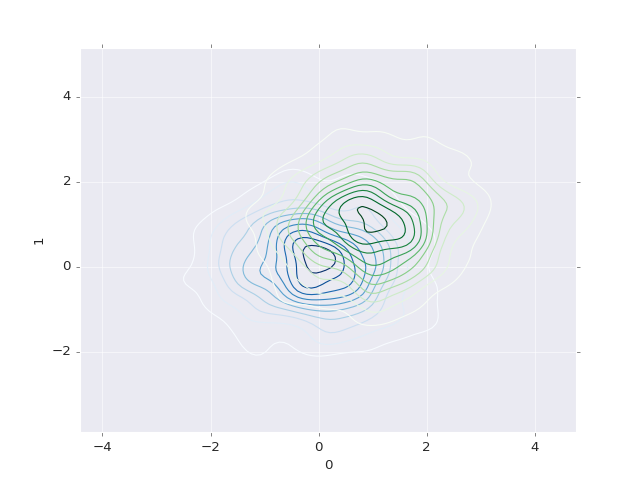

In [64]:
sns.kdeplot(data0[0], data0[1],cmap='Blues')
sns.kdeplot(data1[0], data1[1],cmap='Greens')

<IPython.core.display.Javascript object>


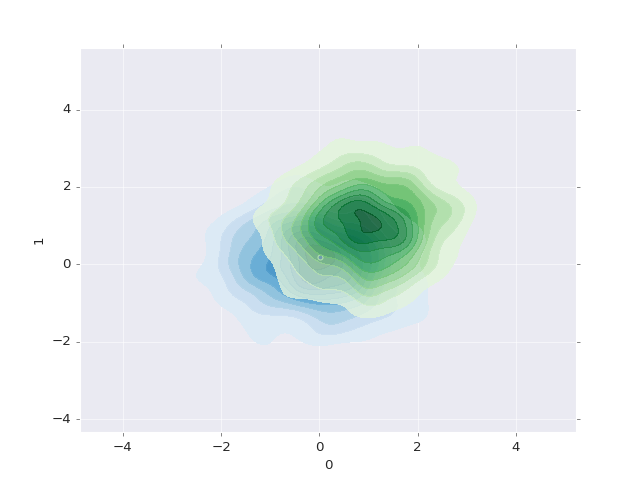

In [68]:
sns.kdeplot(data0[0], data0[1],cmap='Blues',shade=True,shade_lowest=False,alpha=0.75)
sns.kdeplot(data1[0], data1[1],cmap='Greens',shade=True,shade_lowest=False,alpha=0.75)

In [69]:
from scipy.stats import gaussian_kde
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

def density_estimation(m1,m2):
    xmin=min(m1)
    xmax=max(m1)
    ymin=min(m2)
    ymax=max(m2)
    X, Y = numpy.mgrid[xmin:xmax:400j, ymin:ymax:400j]                                                     
    positions = numpy.vstack([X.ravel(), Y.ravel()])                                                       
    values = numpy.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = numpy.reshape(kernel(positions).T, X.shape)
    return X,Y,Z

def find_maxima(X1,X2):
    X,Y,Z = list(density_estimation(X1,X2))
    # Find and filtre peaks by minimum pixel distance and fraction height glob-max
    coordinates = peak_local_max(Z, threshold_rel=0.5, min_distance=20)
    maxima = []
    for k in range(len(coordinates)):
        idx_0,idx_1 = coordinates[k]
        x_max, y_max = X[idx_0][0], Y[idx_0][idx_1]
        maxima.append((x_max, y_max))
    return maxima


* Shaded contour plots
* Position of maxima 

<IPython.core.display.Javascript object>


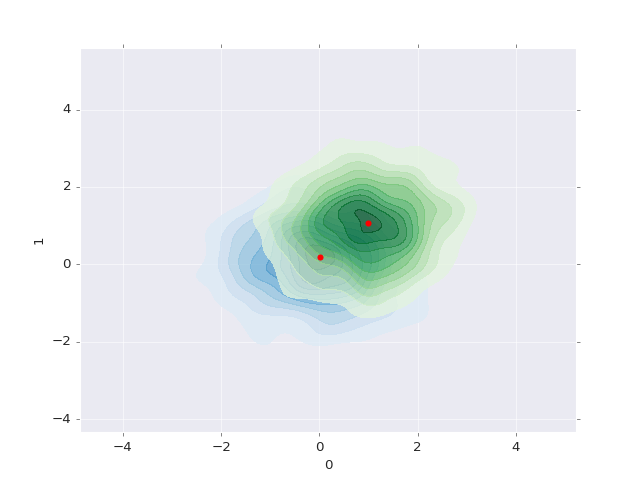

In [92]:
fig, ax = plt.subplots(1,1)

C0 = sns.kdeplot(data0[0], data0[1],cmap='Blues',shade=True,shade_lowest=False,alpha=0.75,ax=ax)
C1 = sns.kdeplot(data1[0], data1[1],cmap='Greens',shade=True,shade_lowest=False,alpha=0.75,ax=ax)

for maximum in find_maxima(data0[0], data0[1]):
    x,y = maximum
    ax.scatter(x,y,color='red',zorder=1)

for maximum in find_maxima(data1[0], data1[1]):
    x,y = maximum
    ax.scatter(x,y,color='red',zorder=1)


plt.show()

<IPython.core.display.Javascript object>


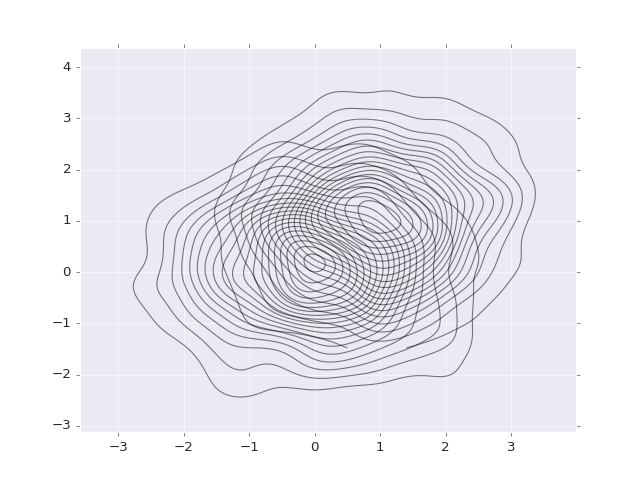

In [133]:
fig, ax = plt.subplots(1,1)

X1,X2 = data0[0],data0[1]
Xc,Yc,Zc = list( density_estimation(X1,X2) )
CS = ax.contour(Xc,Yc,Zc,20,colors='k',alpha=0.5)

X1,X2 = data1[0],data1[1]
Xc,Yc,Zc = list( density_estimation(X1,X2) )
ax.contour(Xc,Yc,Zc,20,colors='k',alpha=0.5)

plt.show()

<IPython.core.display.Javascript object>


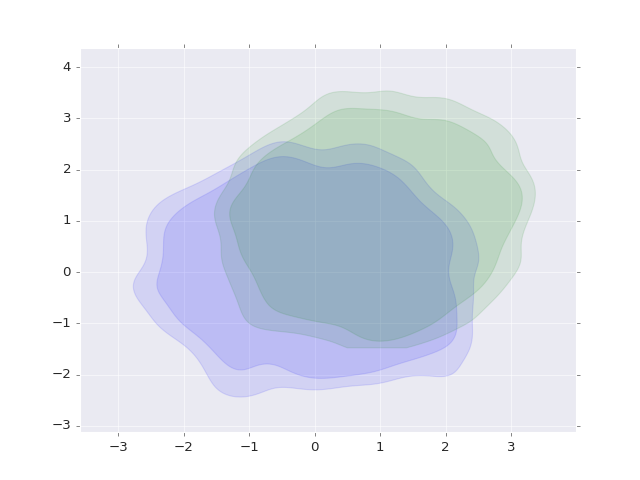

In [143]:
fig, ax = plt.subplots(1,1)

X1,X2 = data0[0],data0[1]
Xc,Yc,Zc = list( density_estimation(X1,X2) )
CS = ax.contour(Xc,Yc,Zc,20,colors='k',alpha=0)

for l in range(len(CS.allsegs)):
    prob = CS.levels[l]
    for k in range(len(CS.allsegs[l])):
        # Extract contour line coordinates
        if prob < 0.017:
            X,Y = CS.allsegs[l][k].T
            ax.fill(X,Y,color='blue',alpha=0.1)

        
X1,X2 = data1[0],data1[1]
Xc,Yc,Zc = list( density_estimation(X1,X2) )
CS = ax.contour(Xc,Yc,Zc,20,colors='k',alpha=0)

for l in range(len(CS.allsegs)):
    prob = CS.levels[l]
    for k in range(len(CS.allsegs[l])):
        # Extract contour line coordinates
        if prob < 0.017:
            X,Y = CS.allsegs[l][k].T
            ax.fill(X,Y,color='green',alpha=0.1)

plt.show()